<a href="https://colab.research.google.com/github/MUYang99/NOx-Time-Series-Prediction-Based-on-Deep-Learning/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
from keras.optimizers import adam_v2
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy import stats, arange
from matplotlib.pyplot import MultipleLocator

# Data Process

In [ ]:
### Import data & dropna
df = pd.read_excel('d2.xlsx')
df.columns = ['Date', 'NOx']
df = df.dropna(subset=['NOx'])
print(df)

                     Date      NOx
0     2015-01-01 00:15:00  62.2314
1     2015-01-01 00:30:00  75.7350
2     2015-01-01 00:45:00  70.4414
5     2015-01-01 01:30:00  29.6205
6     2015-01-01 01:45:00  53.4148
...                   ...      ...
17369 2015-06-30 22:30:00  50.2255
17370 2015-06-30 22:45:00  33.5688
17371 2015-06-30 23:00:00  27.3560
17373 2015-06-30 23:30:00  44.4698
17374 2015-06-30 23:45:00  76.4146

[16992 rows x 2 columns]


In [ ]:
### Data selection(date & NOx)
data = df[df.Date < '20151231']
data = data.drop(["Date"], axis=1)
data = data.values
data = data.reshape(len(data),)

print(data.shape)

(16992,)


In [ ]:
### Average hour data
d1 = data.tolist()
n = len(d1)%4
while n:
  d1.pop()
  n -= 1
m = int(len(d1)/4)
arr = np.array(d1).reshape(m, 4)
avg = np.mean(arr, axis = 1)


print(avg.shape)

(4248,)


In [ ]:
### Data normalization
scaler = MinMaxScaler(feature_range=(0, 1))
avg = avg.reshape(len(avg), 1)
data = scaler.fit_transform(avg)
data = data.reshape(len(data),)

print(data.shape)

(4248,)


# Build dataset

In [ ]:
### Cofigure
n_in = 14*24
n_out = 3*24
n_features = 1
n_val = 1

In [ ]:
### Build data set
def build_dataset(data):

  X, Y = [], []
  for i in range(data.shape[0]-n_in-n_out+1):
    # X.append(np.array(data.iloc[i:i+n_in]))
    # Y.append(np.array(data.iloc[i+n_in:i+n_in+n_out]))
    X.append(np.array(data[i:i+n_in]))
    Y.append(np.array(data[i+n_in:i+n_in+n_out]))

  return np.array(X), np.array(Y)

data_copy = data.copy()
x, y = build_dataset(data_copy)

print(x.shape, y.shape)

(3841, 336) (3841, 72)


In [ ]:
### Split the train and validation datasets
def split_data(x, y):
  
  x_train = x[:-n_val-n_out+1]
  y_train = y[:-n_val-n_out+1]
  x_val = x[-n_val:]
  y_val = y[-n_val:]

  return x_train, y_train, x_val, y_val

x_train, y_train, x_val, y_val = split_data(x, y)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], 1))
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))
y_val = np.reshape(y_val, (y_val.shape[0], y_val.shape[1], 1))
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(3769, 336, 1) (3769, 72, 1) (1, 336, 1) (1, 72, 1)


# LSTM Construction & Training

In [ ]:
### Configure

n_epochs = 30
batchsize = 128
n_neuron = 150

In [ ]:
### Contruct the LSTM
def build_lstm():

  model = Sequential()
  model.add(LSTM(n_neuron, input_shape=(n_in, n_features)))
  #model.add(LSTM(n_neuron, input_shape=(n_in, n_features), return_sequences=True))
  #model.add(LSTM(200, return_sequences=False))
  model.add(Dropout(0.2))
  model.add(Dense(n_out))
  #model.add(Activation("sigmoid"))
  model.compile(optimizer=adam_v2.Adam(learning_rate=1e-4), loss='mae')

  return model

Epoch 1/30
30/30 [==============================] - 26s 822ms/step - loss: 0.1079 - val_loss: 0.0859
Epoch 2/30
30/30 [==============================] - 24s 801ms/step - loss: 0.0907 - val_loss: 0.0636
Epoch 3/30
30/30 [==============================] - 24s 806ms/step - loss: 0.0818 - val_loss: 0.0564
Epoch 4/30
30/30 [==============================] - 24s 800ms/step - loss: 0.0795 - val_loss: 0.0558
Epoch 5/30
30/30 [==============================] - 24s 807ms/step - loss: 0.0788 - val_loss: 0.0551
Epoch 6/30
30/30 [==============================] - 24s 806ms/step - loss: 0.0784 - val_loss: 0.0552
Epoch 7/30
30/30 [==============================] - 25s 817ms/step - loss: 0.0780 - val_loss: 0.0537
Epoch 8/30
30/30 [==============================] - 25s 815ms/step - loss: 0.0777 - val_loss: 0.0539
Epoch 9/30
30/30 [==============================] - 24s 806ms/step - loss: 0.0774 - val_loss: 0.0540
Epoch 10/30
30/30 [==============================] - 24s 811ms/step - loss: 0.0772 - val_lo

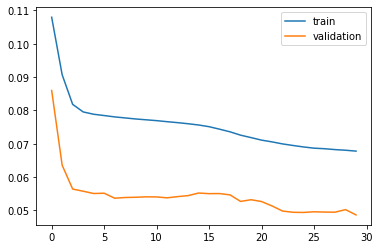

In [ ]:
### Training LSTM
def model_fit(x_train, y_train, x_val, y_val):
    
    model = build_lstm()
    history = model.fit(x_train, y_train, batch_size=batchsize, epochs=n_epochs, verbose=1, validation_data=(x_val, y_val))
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.legend()
    plt.show()
    
    return model

model = model_fit(x_train, y_train, x_val, y_val)

# Results visualization & Analysis

In [ ]:
### Prediction
Prediction = model.predict(x_val)
Prediction = scaler.inverse_transform(Prediction)[0]
Prediction

array([19.444761, 17.272224, 14.145689, 15.812863, 18.47183 , 22.80738 ,
       23.752415, 31.970398, 38.230034, 45.6189  , 54.961586, 59.318092,
       63.193996, 63.73827 , 69.08705 , 70.28397 , 68.10303 , 62.726593,
       57.87847 , 54.125977, 47.50426 , 39.242817, 36.16407 , 32.568718,
       30.338211, 23.583885, 24.727734, 28.047258, 28.983507, 32.580963,
       37.783436, 44.119232, 49.484722, 57.056164, 60.425167, 66.90102 ,
       71.87333 , 77.200424, 72.30402 , 74.299484, 72.28655 , 69.22141 ,
       66.26335 , 53.856045, 53.817516, 48.58758 , 41.454216, 38.706684,
       30.950943, 32.077682, 32.296448, 33.75995 , 34.510918, 43.163364,
       41.35557 , 51.75857 , 60.172726, 62.262684, 68.37095 , 72.44074 ,
       75.852875, 76.55613 , 76.26425 , 75.89192 , 75.01056 , 70.57115 ,
       63.488144, 54.5513  , 49.080425, 45.29252 , 40.02384 , 38.61905 ],
      dtype=float32)

In [ ]:
### Truth
y_val = y_val.reshape(1,n_out)
Truth = scaler.inverse_transform(y_val)[0]
Truth

array([ 23.5114   ,  56.32645  ,  84.604825 ,  77.81465  ,  71.8978   ,
        64.2379   ,  51.294125 ,  32.273875 ,  32.4513   ,  41.6262   ,
        31.6763   ,  43.390275 ,  54.3064   ,  51.55115  ,  79.3205   ,
        72.679175 ,  67.467875 ,  64.964325 ,  64.609525 , 111.440425 ,
       121.753725 ,  46.364625 ,  53.7683   ,  29.22265  ,  40.853775 ,
        37.991225 ,  18.474015 ,  26.081375 ,  19.386595 ,  15.782775 ,
        58.2679425,  77.409975 , 148.04425  , 145.863575 , 205.7359   ,
        95.744425 , 115.78265  , 130.877    ,  99.983875 , 130.684    ,
        91.6474   ,  98.785125 , 111.84435  ,  92.769275 ,  43.958675 ,
        75.871925 ,  50.0538   ,  32.342275 ,  37.977525 ,  43.6175   ,
        25.4063   ,  23.3284   ,  11.4854675,  30.286375 , 102.276475 ,
        93.4573   , 163.2253   , 189.13     , 154.20125  , 157.18455  ,
        69.339575 ,  58.49325  ,  38.989    ,  26.284275 ,  21.40985  ,
        34.85785  ,  18.900725 ,  17.47525  ,  45.116175 ,  44.0

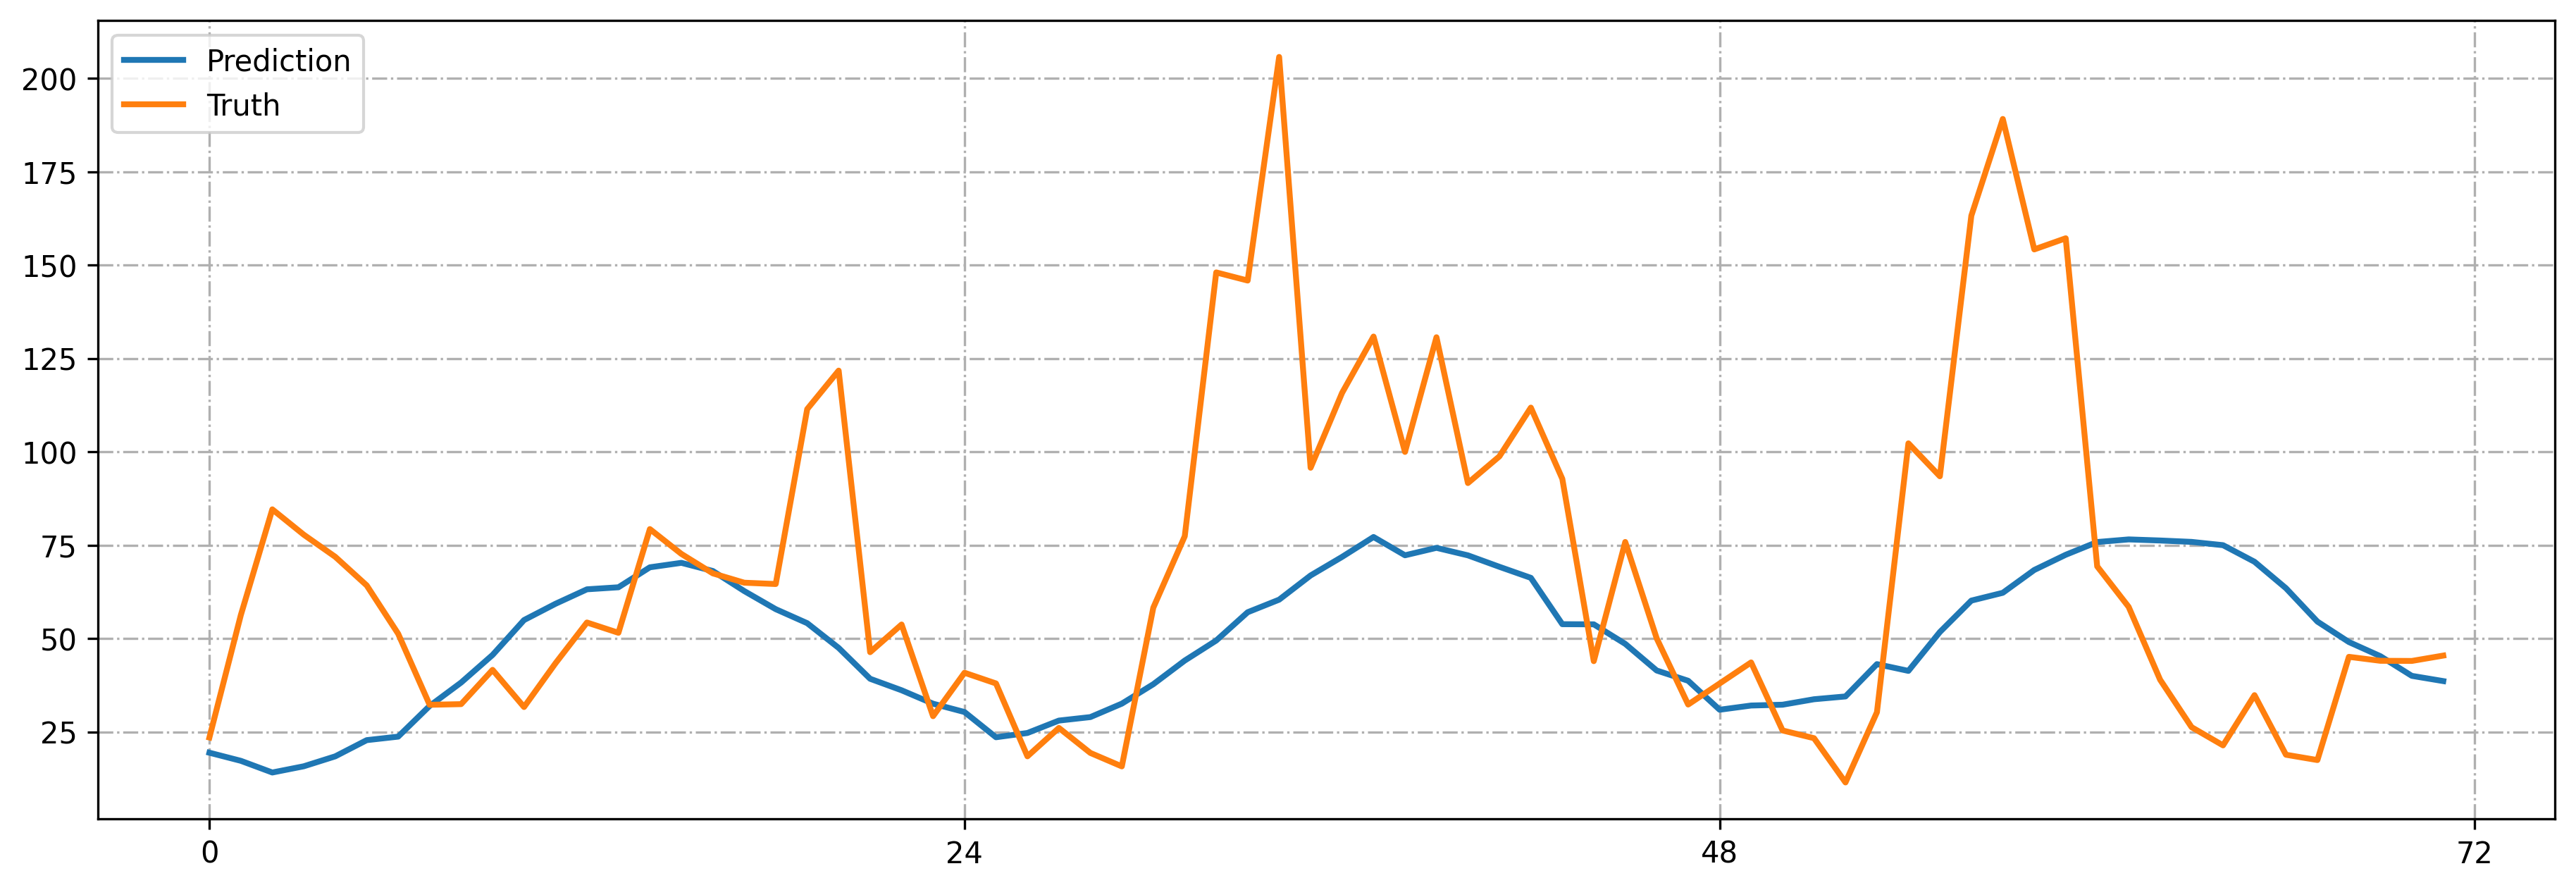

In [ ]:
### Visualization
x = [x for x in range(n_out)]
fig, ax = plt.subplots(figsize=(15,5), dpi = 300)
ax.plot(x, Prediction, linewidth=2.0, label = "Prediction")
ax.plot(x, Truth, linewidth=2.0, label = "Truth")

x_major_locator=MultipleLocator(24)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)

ax.legend(loc=2);
plt.grid(linestyle='-.')
plt.show()

In [ ]:
### Analysis
MSE = mean_squared_error(Truth, Prediction)
RMSE = np.sqrt(MSE)
print('RMSE: %.3f' %RMSE)
MAE = mean_absolute_error(Truth, Prediction)
print('MAE: %.3f' %MAE)

RMSE: 44.410
MAE: 31.467


# Others

In [ ]:
##################################### Box-plot #####################################
# fig = plt.figure(figsize = (10,6))
# ax1 = fig.add_subplot(2,1,1)
# color = dict(boxes='DarkGreen', whiskers='DarkOrange', medians='DarkBlue', caps='Gray')
# d1.plot.box(vert=False, grid = True,color = color,ax = ax1,label = 'NOx data')

# s = data.describe()
# print(s)
# print('------')
# q1 = s['NOx'][4]
# q3 = s['NOx'][6]
# iqr = q3 - q1
# min = q1 - 1.5*iqr
# max = q3 + 1.5*iqr
# print('IQR：%.3f，min：%.3f，max：%.3f' % (iqr,min,max))

# ax2 = fig.add_subplot(3,1,3)
# error = d1['NOx'][(d1['NOx'] < min) | (d1['NOx'] > max)]
# data_c = d1['NOx'][(d1['NOx'] >= min) & (d1['NOx'] <= max)]
# print('The number of outliers: %i' % len(error)) 
# plt.scatter(data_c.index,data_c,color = 'k',marker='.',alpha = 0.3)
# plt.scatter(error.index,error,color = 'r',marker='.',alpha = 0.5)
# plt.grid()

In [ ]:
##################################### Normal-distribution(3 sigma) #####################################
# u = d1['NOx'].mean() 
# std = float(d1['NOx'].std())
# stats.kstest(d1['NOx'], 'norm', (u, std))
# print('Mean：%.3f，Std：%.3f' % (u, std))

# sigma = 3
# fig = plt.figure(figsize = (10,6))
# d1.plot(kind = 'kde',grid = True,style = '-k',title = 'Density curve')
# plt.axvline(sigma*std,color='r',linestyle="--",alpha=0.8) 
# plt.axvline(-sigma*std,color='r',linestyle="--",alpha=0.8)

# error = d1['NOx'][np.abs(d1['NOx'] - u) > sigma*std]
# data_c = d1['NOx'][np.abs(d1['NOx'] - u) <= sigma*std]
# print('The number of outliers: %i' % len(error))
# ax1 = fig.add_subplot(3,1,1)
# plt.scatter(data_c.index,data_c,color = 'k',marker='.',alpha = 0.3)
# plt.scatter(error.index,error,color = 'r',marker='.',alpha = 0.5)
# plt.grid()